<h1>Music Generation</h1>

Preprocessing of dataset

In [ ]:
import os
import json
import music21 as m21
import numpy as np
import tensorflow.keras as keras

In [ ]:
DATASET_DIRECTORY = "dataset"
OUTPUT_DIRECTORY = "processed_dataset"
DATASET_FILE_NAME = "dataset_file"
MAPPING_FILE = "note_mapping.json"
NOTE_SEQUENCE_LENGTH = 64
NOTE_SEQUENCE_LENGTH = int(NOTE_SEQUENCE_LENGTH)

In [ ]:
NOTE_DURATIONS = [
    0.25,  # Sixteenth note
    0.5,   # Eighth note
    0.75,
    1.0,   # Quarter note
    1.5,
    2,     # Half note
    3,
    4      # Whole note
]

In [ ]:
def fetch_kern_songs(dataset_dir):
    kern_songs = []
    for root, directories, filenames in os.walk(dataset_dir):
        for filename in filenames:
            if filename.endswith(".krn"):
                path = os.path.join(root, filename)
                song = m21.converter.parse(path)
                kern_songs.append(song)
    return kern_songs

def check_note_durations(song, allowed_durations):
    for element in song.flat.notesAndRests:
        if element.duration.quarterLength not in allowed_durations:
            return False
    return True

In [ ]:
def change_key(song):
    song_parts = song.getElementsByClass(m21.stream.Part)
    first_part_measures = song_parts[0].getElementsByClass(m21.stream.Measure)
    song_key = first_part_measures[0][4]

    if not isinstance(song_key, m21.key.Key):
        song_key = song.analyze("key")

    if song_key.mode == "major":
        key_change_interval = m21.interval.Interval(song_key.tonic, m21.pitch.Pitch("C"))
    else:
        key_change_interval = m21.interval.Interval(song_key.tonic, m21.pitch.Pitch("A"))

    transposed_song = song.transpose(key_change_interval)
    return transposed_song


In [ ]:
def convert_song_to_text(song, duration_step=0.25):
    song_text = []

    for note_or_rest in song.flat.notesAndRests:
        if isinstance(note_or_rest, m21.note.Note):
            symbol = note_or_rest.pitch.midi
        else:
            symbol = "r"

        duration_steps = int(note_or_rest.duration.quarterLength / duration_step)
        for step in range(duration_steps):
            if step == 0:
                song_text.append(symbol)
            else:
                song_text.append("_")

    song_text = " ".join(str(item) for item in song_text)
    return song_text

In [ ]:
def process_dataset(dataset_dir):
    print("Starting processing...")
    kern_songs = fetch_kern_songs(dataset_dir)
    print(f"{len(kern_songs)} songs have been loaded.")

    for index, song in enumerate(kern_songs):
        if not check_note_durations(song, NOTE_DURATIONS):
            continue

        song = change_key(song)
        song_text = convert_song_to_text(song)

        output_path = os.path.join(OUTPUT_DIRECTORY, str(index))
        with open(output_path, "w") as file_pointer:
            file_pointer.write(song_text)

        if index % 10 == 0:
            print(f"Processed {index} out of {len(kern_songs)}")

In [ ]:
def read_song(file_path):
    with open(file_path, "r") as file_pointer:
        song_text = file_pointer.read()
    return song_text

In [ ]:
def generate_dataset_file(seq_length, dataset_dir, output_file_path):
    song_separator = "/ " * seq_length
    all_songs_text = ""

    for root, _, filenames in os.walk(dataset_dir):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            song_text = read_song(file_path)
            all_songs_text += song_text + " " + song_separator

    all_songs_text = all_songs_text[:-1]

    with open(output_file_path, "w") as file_pointer:
        file_pointer.write(all_songs_text)

    return all_songs_text

def map_songs_to_integers(songs_text, map_path):
    mapping_dict = {}

    songs_elements = songs_text.split()
    unique_elements = list(set(songs_elements))

    for index, element in enumerate(unique_elements):
        mapping_dict[element] = index

    with open(map_path, "w") as file_pointer:
        json.dump(mapping_dict, file_pointer, indent=4)

In [ ]:
def main():
    global NOTE_SEQUENCE_LENGTH
    NOTE_SEQUENCE_LENGTH = int(NOTE_SEQUENCE_LENGTH)
    process_dataset(DATASET_DIRECTORY)
    all_songs_text = generate_dataset_file(NOTE_SEQUENCE_LENGTH, OUTPUT_DIRECTORY, DATASET_FILE_NAME)
    map_songs_to_integers(all_songs_text, MAPPING_FILE)

In [ ]:
if __name__ == "__main__":
    main()

Starting processing...
1700 songs have been loaded.
Processed 0 out of 1700
Processed 10 out of 1700


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\music21\stream\base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Processed 20 out of 1700
Processed 30 out of 1700
Processed 40 out of 1700
Processed 50 out of 1700
Processed 60 out of 1700
Processed 70 out of 1700
Processed 80 out of 1700
Processed 90 out of 1700
Processed 100 out of 1700
Processed 110 out of 1700
Processed 120 out of 1700
Processed 130 out of 1700
Processed 140 out of 1700
Processed 150 out of 1700
Processed 160 out of 1700
Processed 170 out of 1700
Processed 180 out of 1700
Processed 190 out of 1700
Processed 200 out of 1700
Processed 210 out of 1700
Processed 220 out of 1700
Processed 230 out of 1700
Processed 240 out of 1700
Processed 250 out of 1700
Processed 260 out of 1700
Processed 270 out of 1700
Processed 280 out of 1700
Processed 290 out of 1700
Processed 300 out of 1700
Processed 310 out of 1700
Processed 320 out of 1700
Processed 330 out of 1700
Processed 340 out of 1700
Processed 350 out of 1700
Processed 360 out of 1700
Processed 370 out of 1700
Processed 380 out of 1700
Processed 390 out of 1700
Processed 400 out of



Training model




In [ ]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import numpy as np
import json

In [ ]:
SEQUENCE_LENGTH = 64
DATASET_FILE_NAME = 'dataset_file'
MAPPING_PATH = 'note_mapping.json'

In [ ]:
OUTPUT_UNITS = 38
NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 1
BATCH_SIZE = 64
SAVE_MODEL_PATH = "model.h5"

In [ ]:
def load_and_prepare_sequences(sequence_length=SEQUENCE_LENGTH):
    # Load the dataset file
    with open(DATASET_FILE_NAME, 'r') as file:
        songs = file.read()

    # load mapping
    with open(MAPPING_PATH, 'r') as file:
        mappings = json.load(file)

    # converting
    songs_int = [mappings[char] for char in songs if char in mappings]

    # generating the trained sequences
    inputs, targets = [], []
    num_sequences = len(songs_int) - sequence_length
    for i in range(num_sequences):
        inputs.append(songs_int[i:i+sequence_length])
        targets.append(songs_int[i+sequence_length])

    vocabulary_size = len(mappings)
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    targets = np.array(targets)

    return inputs, targets

In [ ]:
def design_model_beka_said(output_units, num_units, loss, learning_rate):

    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.LSTM(num_units[0])(input)
    x = keras.layers.Dropout(0.2)(x)

    output = keras.layers.Dense(output_units, activation="softmax")(x)

    model = keras.Model(input, output)

    model.compile(loss=loss,
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.summary()

    return model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 38)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         302,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 311,846 (1.19 MB)

 Trainable params: 311,846 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1 - Loss: 0.1092, Accuracy: 0.9767, Time: 2364.45 sec


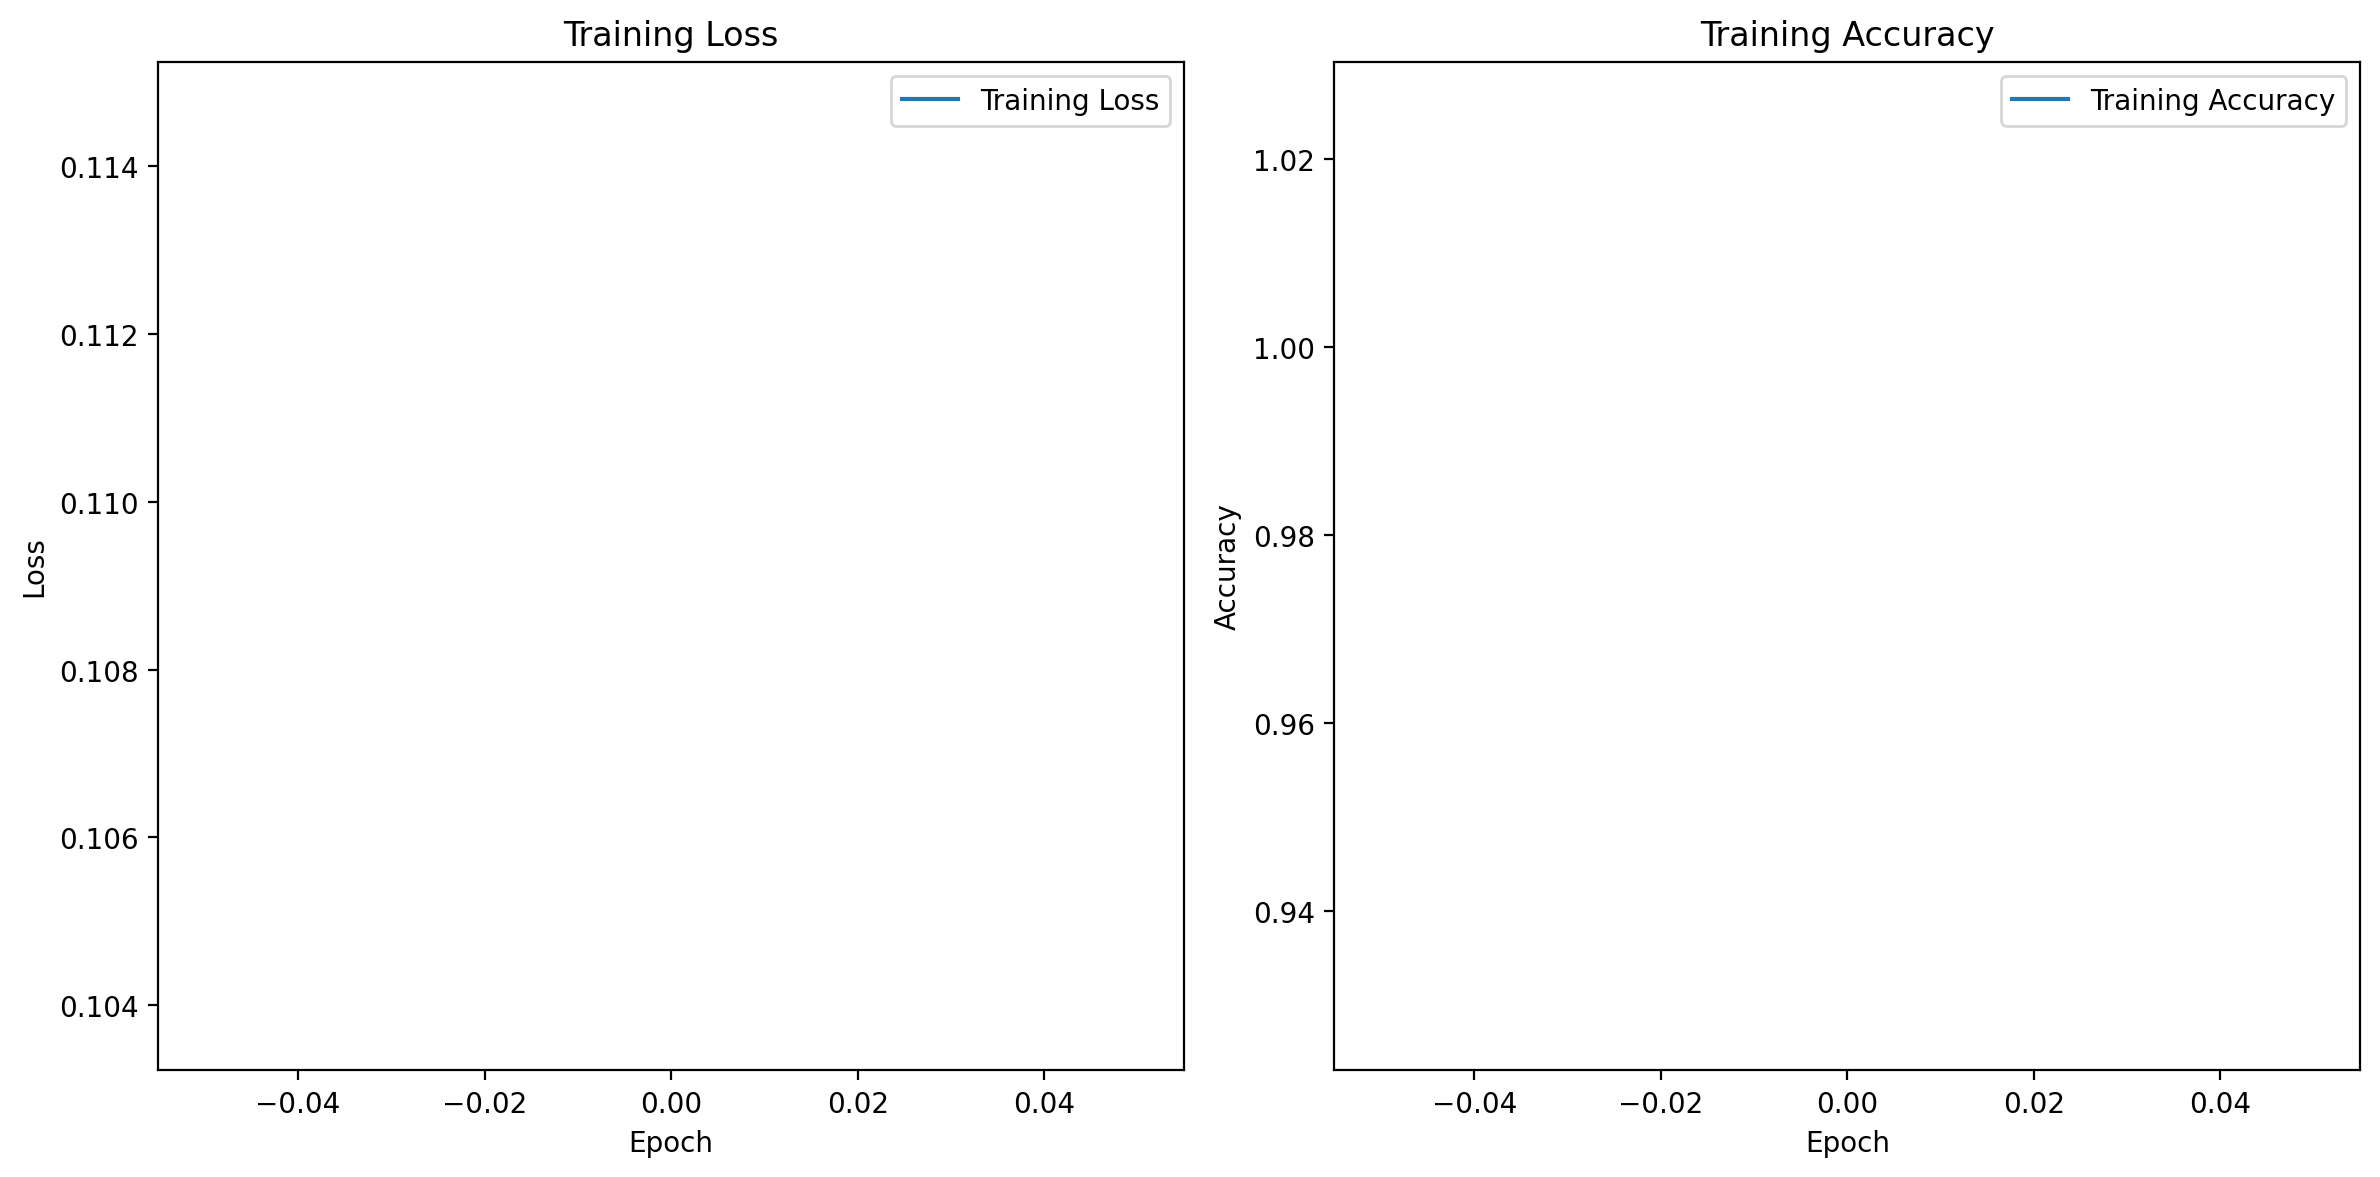

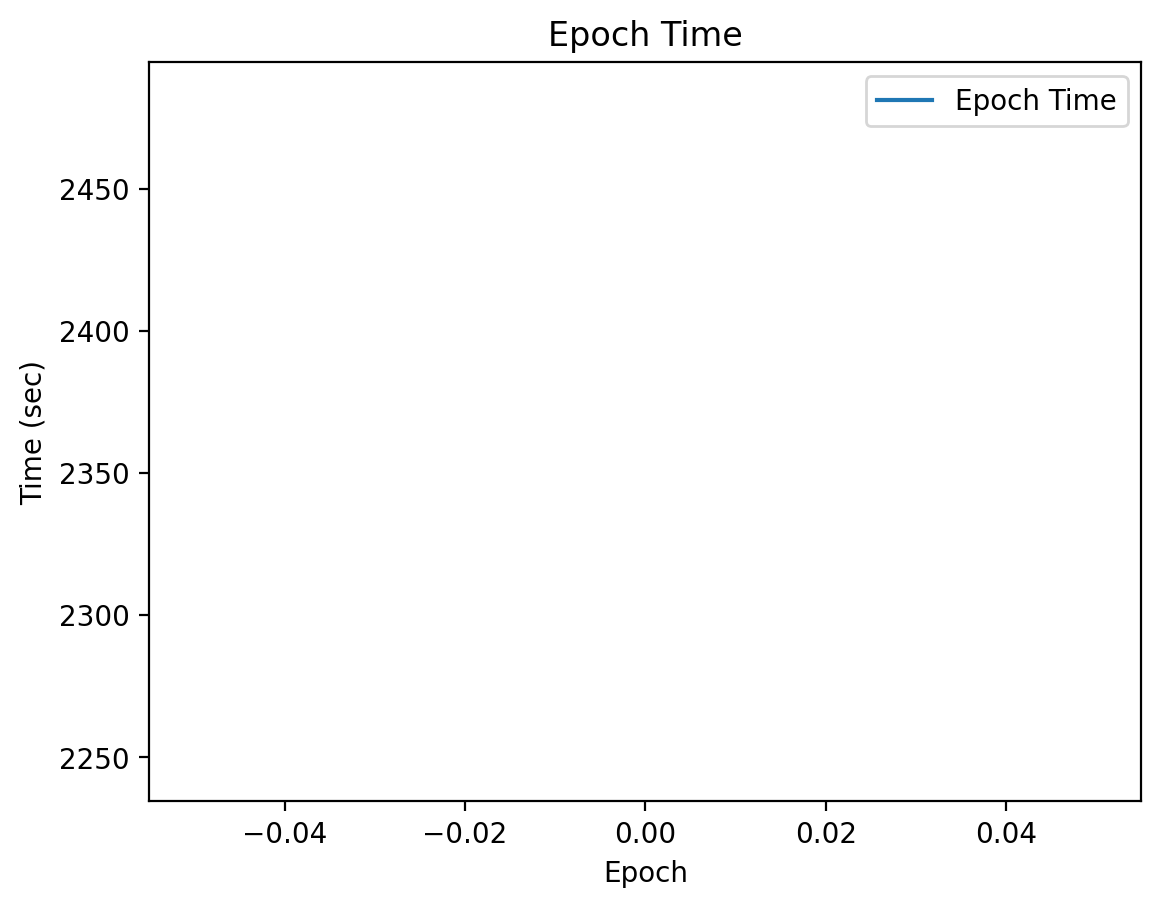

In [ ]:

def train(output_units=OUTPUT_UNITS, num_units=NUM_UNITS, loss=LOSS, learning_rate=LEARNING_RATE):

    inputs, targets = load_and_prepare_sequences(SEQUENCE_LENGTH)

    model = design_model_beka_said(output_units, num_units, loss, learning_rate)

    training_loss = []
    training_accuracy = []
    epoch_times = []

    for epoch in range(EPOCHS):
        start_time = time.time()

        history = model.fit(inputs, targets, epochs=1, batch_size=BATCH_SIZE, verbose=0)

        training_loss.append(history.history['loss'][0])
        training_accuracy.append(history.history['accuracy'][0])

        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1}/{EPOCHS} - "
              f"Loss: {training_loss[-1]:.4f}, "
              f"Accuracy: {training_accuracy[-1]:.4f}, "
              f"Time: {epoch_time:.2f} sec")

    # Plot training history
    plt.figure(figsize=(12, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Optionally plot epoch times
    plt.figure()
    plt.plot(epoch_times, label='Epoch Time')
    plt.title('Epoch Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (sec)')
    plt.legend()
    plt.show()

    model.save(SAVE_MODEL_PATH)

if __name__ == "__main__":
    train()

Generator of music melody in midi format

In [ ]:
import json
import numpy as np
import tensorflow.keras as keras
import random
import music21 as m21
from preprocessing import NOTE_SEQUENCE_LENGTH, MAPPING_FILE
from train import design_model_beka_said, OUTPUT_UNITS

In [ ]:
class MelodyGenerator:
    def __init__(self, model_path="model.h5"):

        self.model_path = model_path
        self.model = keras.models.load_model(model_path)

        with open(MAPPING_FILE, "r") as fp:
            self._mappings = json.load(fp)

        self._start_symbols = ["/"] * NOTE_SEQUENCE_LENGTH


    def generate_melody(self, seed, num_steps, max_sequence_length, temperature):

        seed = seed.split()
        melody = seed
        seed = self._start_symbols + seed

        seed = [self._mappings[symbol] for symbol in seed]

        for _ in range(num_steps):

            seed = seed[-max_sequence_length:]

            onehot_seed = keras.utils.to_categorical(seed, num_classes=len(self._mappings))
            onehot_seed = onehot_seed[np.newaxis, ...]

            probabilities = self.model.predict(onehot_seed)[0]
            output_int = self._sample_with_temperature(probabilities, temperature)

            seed.append(output_int)

            output_symbol = [k for k, v in self._mappings.items() if v == output_int][0]

            if output_symbol == "/":
                break

            melody.append(output_symbol)

        return melody


    def _sample_with_temperature(self, probabilites, temperature):
        predictions = np.log(probabilites) / temperature
        probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

        choices = range(len(probabilites)) # [0, 1, 2, 3]
        index = np.random.choice(choices, p=probabilites)

        return index


    def save_melody(self, melody, step_duration=0.25, format="midi", file_name="melody.midi"):

        stream = m21.stream.Stream()

        start_symbol = None
        step_counter = 1

        for i, symbol in enumerate(melody):

            if symbol != "_" or i + 1 == len(melody):

                if start_symbol is not None:

                    quarter_length_duration = step_duration * step_counter

                    if start_symbol == "r":
                        m21_event = m21.note.Rest(quarterLength=quarter_length_duration)
                    else:
                        m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

                    stream.append(m21_event)

                    step_counter = 1

                start_symbol = symbol

            else:
                step_counter += 1

        stream.write(format, file_name)


def read_random_seed_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

        seeds = [line.strip() for line in lines if line.strip()]
        if not seeds:
            raise ValueError("The dataset file is empty.")
        return random.choice(seeds)

def generate_melody(model, file_dataset):
    seed = read_random_seed_from_file(file_dataset)
    return np.random.randint(0, OUTPUT_UNITS, size=100), seed

if __name__ == "__main__":
    file_dataset = "dataset_file"
    mg = MelodyGenerator()
    melody, used_seed = generate_melody(mg, file_dataset)
    print("Used seed:", used_seed)
    print("Generated melody:", melody)
    mg.save_melody(melody)

Used seed: 55 _ 60 _ 60 _ 60 _ 62 _ 64 _ 62 _ 60 _ _ _ 64 _ 64 _ 64 _ 65 _ 67 _ _ 65 64 _ 60 _ 72 _ _ _ 72 71 69 _ 67 _ _ _ r _ 67 _ 69 _ 65 _ 62 _ 65 _ 67 _ 64 _ 60 _ 62 _ 64 _ 67 _ 65 _ 62 _ 60 _ _ _ r _ 67 _ 69 _ 65 _ 62 _ 65 _ 67 _ 64 _ 60 _ 62 _ 64 _ 67 _ 65 _ 62 _ 60 _ _ _ r _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 55 _ 60 _ 60 _ 60 _ 64 _ 67 _ 64 _ 60 _ _ _ 64 _ 67 _ 67 _ 67 _ 72 _ 67 _ 64 _ 64 _ 67 _ _ _ 69 67 65 64 62 _ _ _ r _ 62 _ 60 _ 64 _ 67 _ 64 _ 62 _ 64 _ 65 _ 62 62 60 _ 64 _ 67 65 62 _ 60 _ _ _ r _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 55 _ 60 _ 60 _ 60 59 60 62 64 65 64 62 60 _ 64 64 65 _ 65 _ 64 _ 64 _ 62 _ _ _ r _ 64 65 67 _ 62 _ 62 64 62 60 59 60 59 57 55 _ 55 55 60 _ 60 _ 62 _ 69 _ 67 _ _ _ 65 _ _ _ 64 _ 64 _ 64 62 62 _ 60 _ _ _ r _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / 